# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP2-SVM-IMA205-YOUR-SURNAME.ipynb') and the answers to the theoretical questions as a single zip file to the site pédagogique before the 12th of February 2020 (23h59). Name it as 'TP2-SVM-IMA205-YOUR-SURNAME.zip'.

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [0]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [3]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

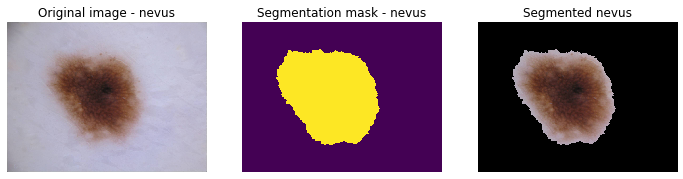

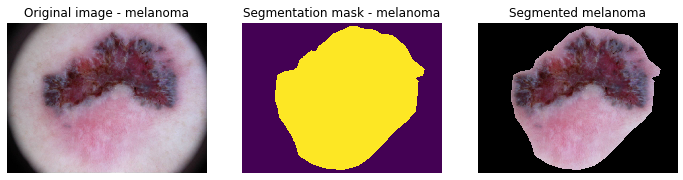

In [4]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [0]:
# Shuffle data randomly. Hint: Use np.random.shuffle
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Use as new variables
Xp=X[indices]
Yp=y[indices]


As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance.

In [0]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(Xp)
X_scale=scaler.transform(Xp)

We should now test the discriminative power of our features. Let divide the entire data-set into training and test set and use two simple classification algorithms, a linear and a quadratic one... Look at the confusion matrices and comment the results. 

---

La classification permet bien de trouver les images de grains de beautés sains, mais pas celles de mélanomes. En effet les mélanomes sont souvent classifiées comme des grains de beauté, puisqu'il s'agit de la classe majoritaire. J'ai choisi d'utiliser LDA et QDA, on remarque que les matrices de confusion sont égales, donc on peut supposer que les matrices de covariances sont égales pour chaque classes.

---

Fitting LDA to training set
done in 0.014s
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       164
           1       0.56      0.56      0.56        34

    accuracy                           0.85       198
   macro avg       0.73      0.73      0.73       198
weighted avg       0.85      0.85      0.85       198

Normalized confusion matrix
[[0.90853659 0.09146341]
 [0.44117647 0.55882353]]


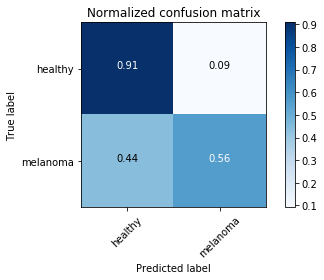

In [7]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scale, np.ravel(Yp), test_size=0.33)

# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Fitting QDA to training set
done in 0.013s
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       164
           1       0.56      0.56      0.56        34

    accuracy                           0.85       198
   macro avg       0.73      0.73      0.73       198
weighted avg       0.85      0.85      0.85       198

Normalized confusion matrix
[[0.90853659 0.09146341]
 [0.44117647 0.55882353]]


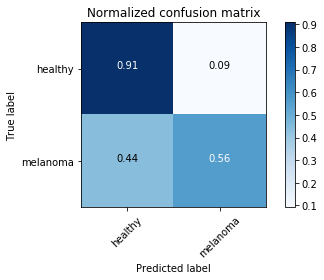

In [8]:
# Fitting QDA to original data 
print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it with at least three different models (e.g. LDA, QDA, K-NN, etc)

---

On peut utiliser la Cross-validation, c'est à dire découper notre échantillon en X sets de même taille, puis entrainer successivement le modèle en considérant l'un à tour de l'autre les sets comme le set de test, et le reste comme le set de train. A partir de ces différents tests l'algorithme calcule le pouvoir de prédiction du modèle.

---

In [9]:

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda_scale = LinearDiscriminantAnalysis()
lda_score_scale = cross_val_score(lda_scale,X=X_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score_scale.mean(), lda_score_scale.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda_scale = QuadraticDiscriminantAnalysis()
qda_score_scale = cross_val_score(qda_scale,X=X_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score_scale.mean(), qda_score_scale.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit_scale = LogisticRegression(solver='lbfgs')
logit_score_scale = cross_val_score(logit_scale,X=X_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score_scale.mean(), logit_score_scale.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB_scale = GaussianNB()
GNB_score_scale = cross_val_score(GNB_scale,X=X_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score_scale.mean(), GNB_score_scale.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh_scale = KNeighborsClassifier(n_neighbors=3)
neigh_score_scale = cross_val_score(neigh_scale,X=X_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score_scale.mean(), neigh_score_scale.std() ))

Fitting LDA
done in 0.042s
 Average and std CV score : 0.8150000000000001 +- 0.02438123139721298
Fitting QDA
done in 0.024s
 Average and std CV score : 0.7983333333333335 +- 0.02494438257849293
Fitting Logistic Regression
done in 0.137s
 Average and std CV score : 0.8200000000000001 +- 0.017950549357115004
Fitting Naive-Bayes
done in 0.016s
 Average and std CV score : 0.7649999999999999 +- 0.043269183285823895
Fitting K-nearest neighbour
done in 0.081s
 Average and std CV score : 0.8166666666666668 +- 0.038369548110737804


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value. Do it and plot the confusion matrix. Do you notice anything strange ? 

---

Notre modèle classe toutes les images comme des grains de beautés sains. En effet, la classe des grains de beauté cancéreux est sous représentée dans nos données, ils sont donc automatiquement classés dans la classe majoritaire. Pour corriger ce biais, nous devons utiliser l'over-sampling.

---

The best K is 14  with an average validation score equal to  0.8034876543209876
The test score is 0.8434343434343434


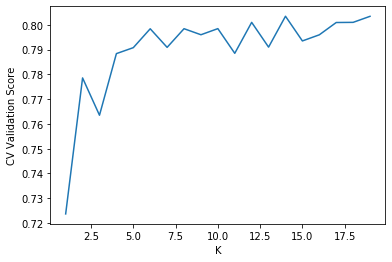

In [10]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[i for i in range(20)]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
K=grid.best_params_.get('n_neighbors')
print('The best K is', K, ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([i for i in range(20)], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))

Fitting KNN to training set
done in 0.018s
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       164
           1       0.60      0.26      0.37        34

    accuracy                           0.84       198
   macro avg       0.73      0.61      0.64       198
weighted avg       0.82      0.84      0.82       198

Normalized confusion matrix
[[0.96341463 0.03658537]
 [0.73529412 0.26470588]]


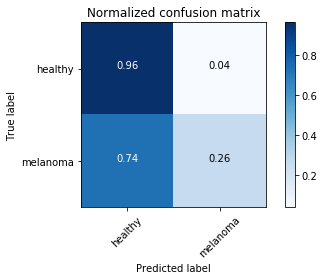

In [11]:
# Fitting KNN to original data
print("Fitting KNN to training set")
t0 = time()
neigh=KNeighborsClassifier(n_neighbors=K)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
time_calcul=(time() - t0)
print("done in %0.3fs" % (time_calcul))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

I strongly suggest that you look at these two web-pages: 
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter, and try other scoring functions with at least one of the 3 previous models.
- https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html and try at least one naive random over-sampling (look at the following code...).

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

# Fitting LDA  using balanced_accuracy
print("Fitting LDA using balanced_accuracy")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X_scale, y,cv=5,scoring='balanced_accuracy')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting LDA using f1
print("Fitting LDA using f1")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X_scale, y,cv=5,scoring='f1')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting LDA using accuracy
print("Fitting LDA using accuracy")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X_scale, y,cv=5,scoring='accuracy')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

Fitting LDA using balanced_accuracy
done in 0.050s
 Average and std CV score : 0.49713133124159575 +- 0.008107132189435647
Fitting LDA using f1
done in 0.045s
 Average and std CV score : 0.015384615384615382 +- 0.030769230769230767
Fitting LDA using accuracy
done in 0.039s
 Average and std CV score : 0.7983333333333335 +- 0.0062360956446232615


--- 

Accuracy obtient les meilleurs scores, cependant balanced_accuracy permet de mieux prendre en compte le fait que les classes ne sont pas équilibrées. 

---

In [12]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X_scale, Yp, test_size=0.33, random_state=2)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 322), (1, 322)]


Let's retest KNN on this new data-set. Are the results better ?

--- 

Les résultats pour classer les grains de beauté sains sont moins bon, mais on obtient de meilleurs résultats que précedemment pour les grains de beauté malades. On échappe donc à l'effet d'une classe majoritaire grace à l'over-sampling. Les méthodes utilisées ne permettent cependant pas de bien distinguer les grains de beautés sains et malades, nous devons donc utiliser d'autres méthodes de classification.

---

Fitting KNN to training set
done in 0.023s
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       163
           1       0.35      0.69      0.47        35

    accuracy                           0.72       198
   macro avg       0.63      0.71      0.64       198
weighted avg       0.82      0.72      0.75       198

Normalized confusion matrix
[[0.73006135 0.26993865]
 [0.31428571 0.68571429]]


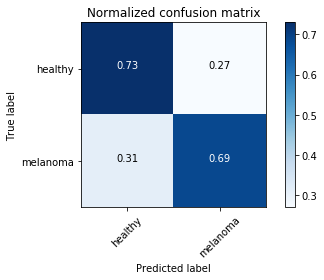

In [13]:
## Fitting KNN to original data
print("Fitting KNN to training set")
t0 = time()
neigh=KNeighborsClassifier(n_neighbors=K)
neigh.fit(X_resampled, y_resampled)
y_pred = neigh.predict(X_test)
time_calcul=(time() - t0)
print("done in %0.3fs" % (time_calcul))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use more advanced techiques such as SVM


In [53]:
# Fitting Linear SVM on original data with accuracy score
print("Fitting Linear SVM to the training set using accuracy score")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm,X=X_scale, y=np.ravel(Yp),cv=5,scoring='accuracy')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(),Lsvm_score.std() ))


# Fitting Linear SVM on original data with balanced_accuracy score
print("Fitting Linear SVM to the training set using balanced_accuracy score")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm,X=X_scale, y=np.ravel(Yp),cv=5,scoring='balanced_accuracy')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(),Lsvm_score.std() ))


# Fitting Linear SVM on original data with f1 score
print("Fitting Linear SVM to the training set using f1 score")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm,X=X_scale, y=np.ravel(Yp),cv=5,scoring='f1')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(),Lsvm_score.std() ))




Fitting Linear SVM to the training set using accuracy score
done in 0.303s
 Average and std CV score : 0.7233333333333333 +- 0.026562295750848737
Fitting Linear SVM to the training set using balanced_accuracy score
done in 0.302s
 Average and std CV score : 0.6673688928731509 +- 0.05650063890294558
Fitting Linear SVM to the training set using f1 score
done in 0.300s
 Average and std CV score : 0.4497502497502497 +- 0.08187518674205088


---

Accuracy et balanced_accuracy envoie de bons scores, donc nous utiliserons ces deux méthodes, la première si on utilise l'over-sampling et la seconde si les classes ne sont pas équilibrées

---

Suppose that there are overlapping classes, we need to set the hyper-parameter C. Use Cross-Validation to find the best C value.

The best C is {'C': 0.001}  with an average validation score equal to  0.6991483639623487


Text(0, 0.5, 'CV Validation Score')

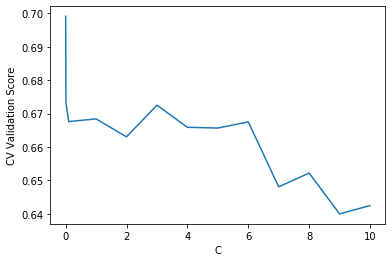

In [54]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced', C=p_grid_lsvm)

grid = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, n_jobs=-1, scoring='balanced_accuracy')
grid.fit(X_scale, Yp)

print('The best C is', grid.best_params_, ' with an average validation score equal to ', grid.best_score_)
C_best=grid.best_params_['C']

# plot the CV validation score for each K value
plt.plot([1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1], grid.cv_results_.get('mean_test_score'))
plt.xlabel('C')
plt.ylabel('CV Validation Score')

Try to use the previous SVM code but on the over-sampled data. Does the scoring result change ? 

---

Le SVM semble être moins sensible à l'over-sampling que K-neighbors, en effet le résultat ne change que légèrement.

---

In [56]:
print("Fitting Linear SVM to the over-sampled data")
t0 = time()
Lsvm = LinearSVC(C=C_best)
Lsvm_score = cross_val_score(Lsvm,X= X_resampled, y=np.ravel(y_resampled) ,cv=5,scoring='accuracy')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(), Lsvm_score.std() ))

Fitting Linear SVM to the over-sampled data
done in 0.028s
 Average and std CV score : 0.7190285852713179 +- 0.0375914747869987


done in 0.013s
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       163
           1       0.35      0.69      0.47        35

    accuracy                           0.72       198
   macro avg       0.63      0.71      0.64       198
weighted avg       0.82      0.72      0.75       198

Normalized confusion matrix
[[0.71779141 0.28220859]
 [0.31428571 0.68571429]]


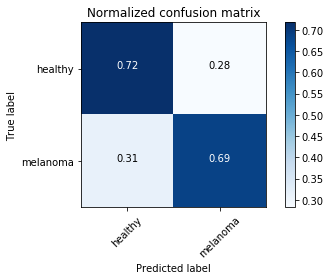

In [44]:
Lsvm = LinearSVC(C=C_best)
t0=time()
Lsvm.fit(X_resampled, y_resampled)
y_svc_ = Lsvm.predict(X_test)
time_calcul=(time() - t0)
print("done in %0.3fs" % (time_calcul))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_svc_)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

In [57]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
nested_score = cross_val_score(clf, X_resampled, y_resampled, cv=outer_cv)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))

# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="balanced_accuracy", cv=5)
grid_nlsvm.fit(X_scale,Yp)
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))

Fitting Non-linear SVM to the training set
done in 34.085s
Average and std Nested Cv score : 0.9456516472868216 +- 0.009806978293302076
Best Score: 0.7078888390856118
Best params: {'C': 10.0, 'gamma': 0.005}


Another important point is the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. balanced accuracy). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [0]:
nombre_features=5
n=len(X_train[0])
best_features = []
liste=[i for i in range(n)]
while len(best_features)<nombre_features:
  model = LinearSVC(C=C_best)
  best=liste[len(liste)-1]
  features = best_features.copy()
  features.append(best)
  model.fit(X_train[:,features], y_train)
  best_score=model.score(X_test[:,features], y_test)
  for i in liste:
      if i not in best_features:
        model = LinearSVC(C=C_best)
        features_test= best_features.copy()
        features_test.append(i)
        model.fit(X_train[:,features_test], y_train)
        score=model.score(X_test[:,features_test], y_test)
        if score>best_score:
          best=i
          best_score=score
  liste.pop(liste.index(best))  
  best_features.append(best)

In [58]:
print("Liste des features sélectionnées")
print(best_features)

Liste des features sélectionnées
[0, 1, 29, 17, 28]


done in 0.003s
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       163
           1       0.35      0.69      0.47        35

    accuracy                           0.72       198
   macro avg       0.63      0.71      0.64       198
weighted avg       0.82      0.72      0.75       198

Normalized confusion matrix
[[0.73006135 0.26993865]
 [0.37142857 0.62857143]]


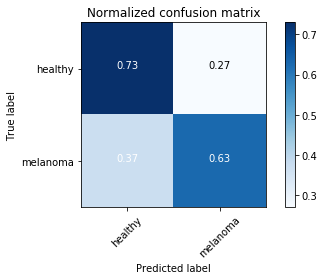

In [59]:
Lsvm = LinearSVC(C=C_best)
t0=time()
Lsvm.fit(X_resampled[:,best_features], y_resampled)
y_svc_ = Lsvm.predict(X_test[:,best_features])
time_calcul=(time() - t0)
print("done in %0.3fs" % (time_calcul))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_svc_)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

--- 

Les résultats sont assez similaires à ceux avant la sélection, d'ailleurs avec 7 features on obtient exactement les mêmes résultats. Ces 7 features sont donc suffisantes. Le temps de calcul est beaucoup plus court qu'avant la sélection de features. 

---